In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import re
import csv
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
data = pd.read_csv('/content/dataset_processed.csv')

In [6]:
data = data[['Sentiment', 'Processed Text']]

In [7]:
data.head()

,Sentiment,Processed Text
0,Positive,নাটক টা সত্যি অনেক সুন্দর লাগছে
1,Positive,সুন্দর হইছে মম্মা।
2,Negative,সেরা ফালতু নাটক ১টা
3,Positive,গানটা অছাম
4,Negative,বোকা নির্বোদ


In [8]:
data['Processed Text'] = data['Processed Text'].apply(lambda x: x.lower())
data['Processed Text'] = data['Processed Text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['Sentiment'] == 'Positive'].size) #Positive
print(data[ data['Sentiment'] == 'Negative'].size) #Negative

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['Processed Text'].values)
X = tokenizer.texts_to_sequences(data['Processed Text'].values)
X = pad_sequences(X)

17000
6614


In [9]:
Y = pd.get_dummies(data['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7910, 25) (7910, 2)
(3897, 25) (3897, 2)


In [10]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 128)           256000    
                                                                 
 spatial_dropout1d (Spatial  (None, 25, 128)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511194 (1.95 MB)
Trainable params: 511194 (1.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [11]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
248/248 - 42s - loss: 0.5974 - accuracy: 0.7190 - 42s/epoch - 171ms/step
Epoch 2/10
248/248 - 28s - loss: 0.5826 - accuracy: 0.7205 - 28s/epoch - 114ms/step
Epoch 3/10
248/248 - 29s - loss: 0.5715 - accuracy: 0.7258 - 29s/epoch - 117ms/step
Epoch 4/10
248/248 - 29s - loss: 0.5648 - accuracy: 0.7319 - 29s/epoch - 118ms/step
Epoch 5/10
248/248 - 29s - loss: 0.5608 - accuracy: 0.7335 - 29s/epoch - 119ms/step
Epoch 6/10
248/248 - 29s - loss: 0.5575 - accuracy: 0.7341 - 29s/epoch - 115ms/step
Epoch 7/10
248/248 - 28s - loss: 0.5551 - accuracy: 0.7336 - 28s/epoch - 113ms/step
Epoch 8/10
248/248 - 28s - loss: 0.5543 - accuracy: 0.7339 - 28s/epoch - 115ms/step
Epoch 9/10
248/248 - 28s - loss: 0.5532 - accuracy: 0.7344 - 28s/epoch - 113ms/step
Epoch 10/10
248/248 - 28s - loss: 0.5528 - accuracy: 0.7340 - 28s/epoch - 113ms/step


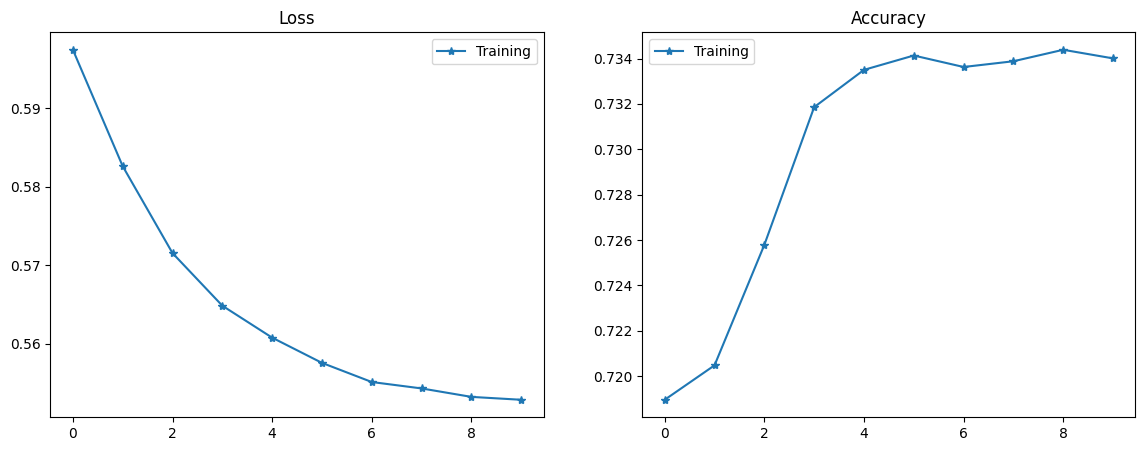

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = '*', label = 'Training')
# plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = '*', label = 'Training')
# plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()

In [13]:
validation_size = 1500
print(X_test.shape,Y_test.shape)
X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 32)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

(3897, 25) (3897, 2)
75/75 - 1s - loss: 0.6137 - accuracy: 0.7096 - 1s/epoch - 17ms/step
score: 0.61
acc: 0.71


In [14]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):

    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]

    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1

    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 238ms/epoch - 238ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 2

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred=model.predict(X_test)
y_pred = (y_pred > 0.5)
print('Classification Report:\n', classification_report(Y_test, y_pred))

75/75 [==============================] - 1s 8ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.02      0.04       697
           1       0.71      0.99      0.83      1700

   micro avg       0.71      0.71      0.71      2397
   macro avg       0.61      0.51      0.44      2397
weighted avg       0.66      0.71      0.60      2397
 samples avg       0.71      0.71      0.71      2397



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
t1 = ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred))
t1.plot()